# Predictions for the NEOCP using current criteria

In this notebook we show our predictions for the near-Earth object confirmation page in the Era of LSST when using current submission criteria.

You can find the code creating Figures 1, 3 & 4.

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [4]:
import pandas as pd

import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
from astropy.time import Time
import astropy.units as u

from datetime import date

import numpy as np
from os import listdir

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

import helpers

import difi

In [5]:
import sys
sys.path.append("../mitigation_algorithm/")
import magnitudes

In [6]:
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.6 * fs,
          'ytick.labelsize': 0.6 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

In [7]:
from importlib import reload

# Set up S3M ID conversion

In [8]:
s3m = pd.read_hdf("../../hybrid-sso-catalogs/catalogues/s3m_initial.h5")
hex_ids = np.array(['{:07X}'.format(num) for num in np.arange(len(s3m.index.values))])
s3m_to_hex7 = dict(zip(s3m.index.values, hex_ids))

# Get `digest2` scores

### Attach extra info to files

In [43]:
def attach_nobs_scores_to_files(file_ids=range(22), path="mba/"):
    # go through each visit file
    for file in file_ids:
        print(f"Starting file {file}")
        # read in the file and set hex_id as the index
        visit_file = pd.read_hdf(path + f"filtered_visit_{file:03d}.h5")
        visit_file.set_index("hex_id", inplace=True)

        # get a list of nights in the file
        nights = np.sort(visit_file["night"].unique())
        nightly_visits = [None for _ in range(len(nights))]

        # loop over the nights
        for i, night in enumerate(nights):
            if night > 372:
                break
            # get the specific rows for this night
            nightly_visit_file = visit_file[visit_file["night"] == night]

            # calculate n_obs for each row and save as a new column
            n_obs = nightly_visit_file.groupby("ObjID").size().to_frame("n_obs")
            nightly_visit_file = nightly_visit_file.join(n_obs, on="ObjID")

            # read in the scores, remove duplicates
            scores, hex_ids = helpers.get_neo_scores(path, night=night)
            
            uni, inds = np.unique(hex_ids, return_index=True)

            # add scores as a new column
            scores_df = pd.DataFrame(dict(scores=scores[inds], hex_id=hex_ids[inds])).set_index("hex_id")
            nightly_visits[i] = nightly_visit_file.join(scores_df, on="hex_id")

            print(f"  Done with night {night}")

        # recombine the dataframes and save as a new file
        visit_file = pd.concat(nightly_visits)
        visit_file.to_hdf(path + f"filtered_visit_scores_{file:03d}.h5", key="df")

        print(f"  Done saving")

In [44]:
%%time
attach_nobs_scores_to_files(path="neo/")

Starting file 0
  Done with night 0
  Done with night 1
  Done with night 2
  Done with night 3
  Done with night 4
  Done with night 5
  Done with night 6
  Done with night 7
  Done with night 8
  Done with night 9
  Done with night 10
  Done with night 11
  Done with night 12
  Done saving
Starting file 1
  Done with night 12
  Done with night 13
  Done with night 14
  Done with night 15
  Done with night 16
  Done with night 17
  Done with night 18
  Done with night 20
  Done with night 21
  Done with night 22
  Done with night 23
  Done with night 24
  Done with night 25
  Done with night 26
  Done with night 28
  Done saving
Starting file 2
  Done with night 28
  Done with night 29
  Done with night 30
  Done with night 31
  Done with night 32
  Done with night 33
  Done with night 41
  Done with night 42
  Done with night 43
  Done with night 44
  Done with night 45
  Done with night 46
  Done with night 47
  Done with night 48
  Done saving
Starting file 3
  Done with night 48
 

In [45]:
%%time
attach_nobs_scores_to_files(path="mba/")

Starting file 0
  Done with night 0
  Done with night 1
  Done with night 2
  Done with night 3
  Done with night 4
  Done with night 5
  Done with night 6
  Done with night 7
  Done with night 8
  Done with night 9
  Done with night 10
  Done with night 11
  Done with night 12
  Done saving
Starting file 1
  Done with night 12
  Done with night 13
  Done with night 14
  Done with night 15
  Done with night 16
  Done with night 17
  Done with night 18
  Done with night 20
  Done with night 21
  Done with night 22
  Done with night 23
  Done with night 24
  Done with night 25
  Done with night 26
  Done with night 28
  Done saving
Starting file 2
  Done with night 28
  Done with night 29
  Done with night 30
  Done with night 31
  Done with night 32
  Done with night 33
  Done with night 41
  Done with night 42
  Done with night 43
  Done with night 44
  Done with night 45
  Done with night 46
  Done with night 47
  Done with night 48
  Done saving
Starting file 3
  Done with night 48
 

### Get scores for different n_obs

In [182]:
neo_streakers = pd.read_hdf("../mitigation_algorithm/neo_streakers.h5")
streaker_ids = neo_streakers["ObjID"].values

In [171]:
def get_counts(path="neo/", n_obs_list=[3, 3, 4, 5, 6], last_night=373, remove_streaks=True):
    counts = np.zeros((last_night, len(n_obs_list))).astype(int)
    n_too_faint = 0
    
    for file in range(22):
        print(f"file {file}")
        visit_file = pd.read_hdf(path + f"filtered_visit_scores_{file:03d}.h5")
        nights = visit_file["night"].unique()
        for night in nights:
            if night >= last_night:
                break
            nightly_visit = visit_file[visit_file["night"] == night]
            grouped = nightly_visit.groupby("hex_id").first()

            if path == "neo/" and remove_streaks:
                no_streaks = ~(np.isin(grouped["ObjID"], neo_streakers["ObjID"][neo_streakers["night"] == night]))
                grouped = grouped[no_streaks]
                
            out_v_mag = magnitudes.convert_colour_mags(grouped["MaginFilter"].values, out_colour="V", in_colour=grouped["filter"].values)
            
            for i, n_obs in enumerate(n_obs_list):
                no_mag_mask = (grouped["n_obs"] >= n_obs) & (grouped["scores"] >= 65)
                full_mask = no_mag_mask & (out_v_mag <= 22)
                
                if i == 0:
                    n_too_faint += (no_mag_mask.sum() - full_mask.sum())
                    counts[night, i] += no_mag_mask.sum()
                else:
                    counts[night, i] += full_mask.sum()

    print(n_too_faint)
                    
    return counts

In [173]:
%%time
neo_counts = get_counts()

file 0
file 1
file 2
file 3
file 4
file 5
file 6
file 7
file 8
file 9
file 10
file 11
file 12
file 13
file 14
file 15
file 16
file 17
file 18
file 19
file 20
file 21
7172
CPU times: user 1.92 s, sys: 67.6 ms, total: 1.99 s
Wall time: 1.98 s


In [168]:
7172 / (7172 + neo_counts[:, 1].sum())

0.5830420291033249

In [132]:
%%time
mba_counts = get_counts(path="mba/")

file 0
file 1
file 2
file 3
file 4
file 5
file 6
file 7
file 8
file 9
file 10
file 11
file 12
file 13
file 14
file 15
file 16
file 17
file 18
file 19
file 20
file 21
138541
CPU times: user 32.5 s, sys: 3.27 s, total: 35.7 s
Wall time: 35.3 s


In [133]:
138541 / (138541 + mba_counts[:, 1].sum())

0.30265713305763636

## NEOCP Traffic and Purity using current criteria

In [160]:
nights = np.arange(373)
n_obs_list = [3, 4, 5, 6]

In [161]:
total_traffic = neo_counts + mba_counts

In [162]:
bad_weather = nights[total_traffic[:, 0] == 0]

In [163]:
purity = neo_counts / total_traffic

/tmp/ipykernel_20046/4177174142.py:1: RuntimeWarning: invalid value encountered in true_divide
  purity = neo_counts / total_traffic


In [141]:
def weekly_mean(x, bad_weather, size=3):
    y = np.repeat(np.nan, len(x))
    for i in range(len(x)):
        if i not in bad_weather:
            inds = np.arange(max(0, i - size), min(i + size + 1, len(x)))
            inds = inds[~np.isin(inds, bad_weather)]
            y[i] = np.mean(x[inds])
    return y

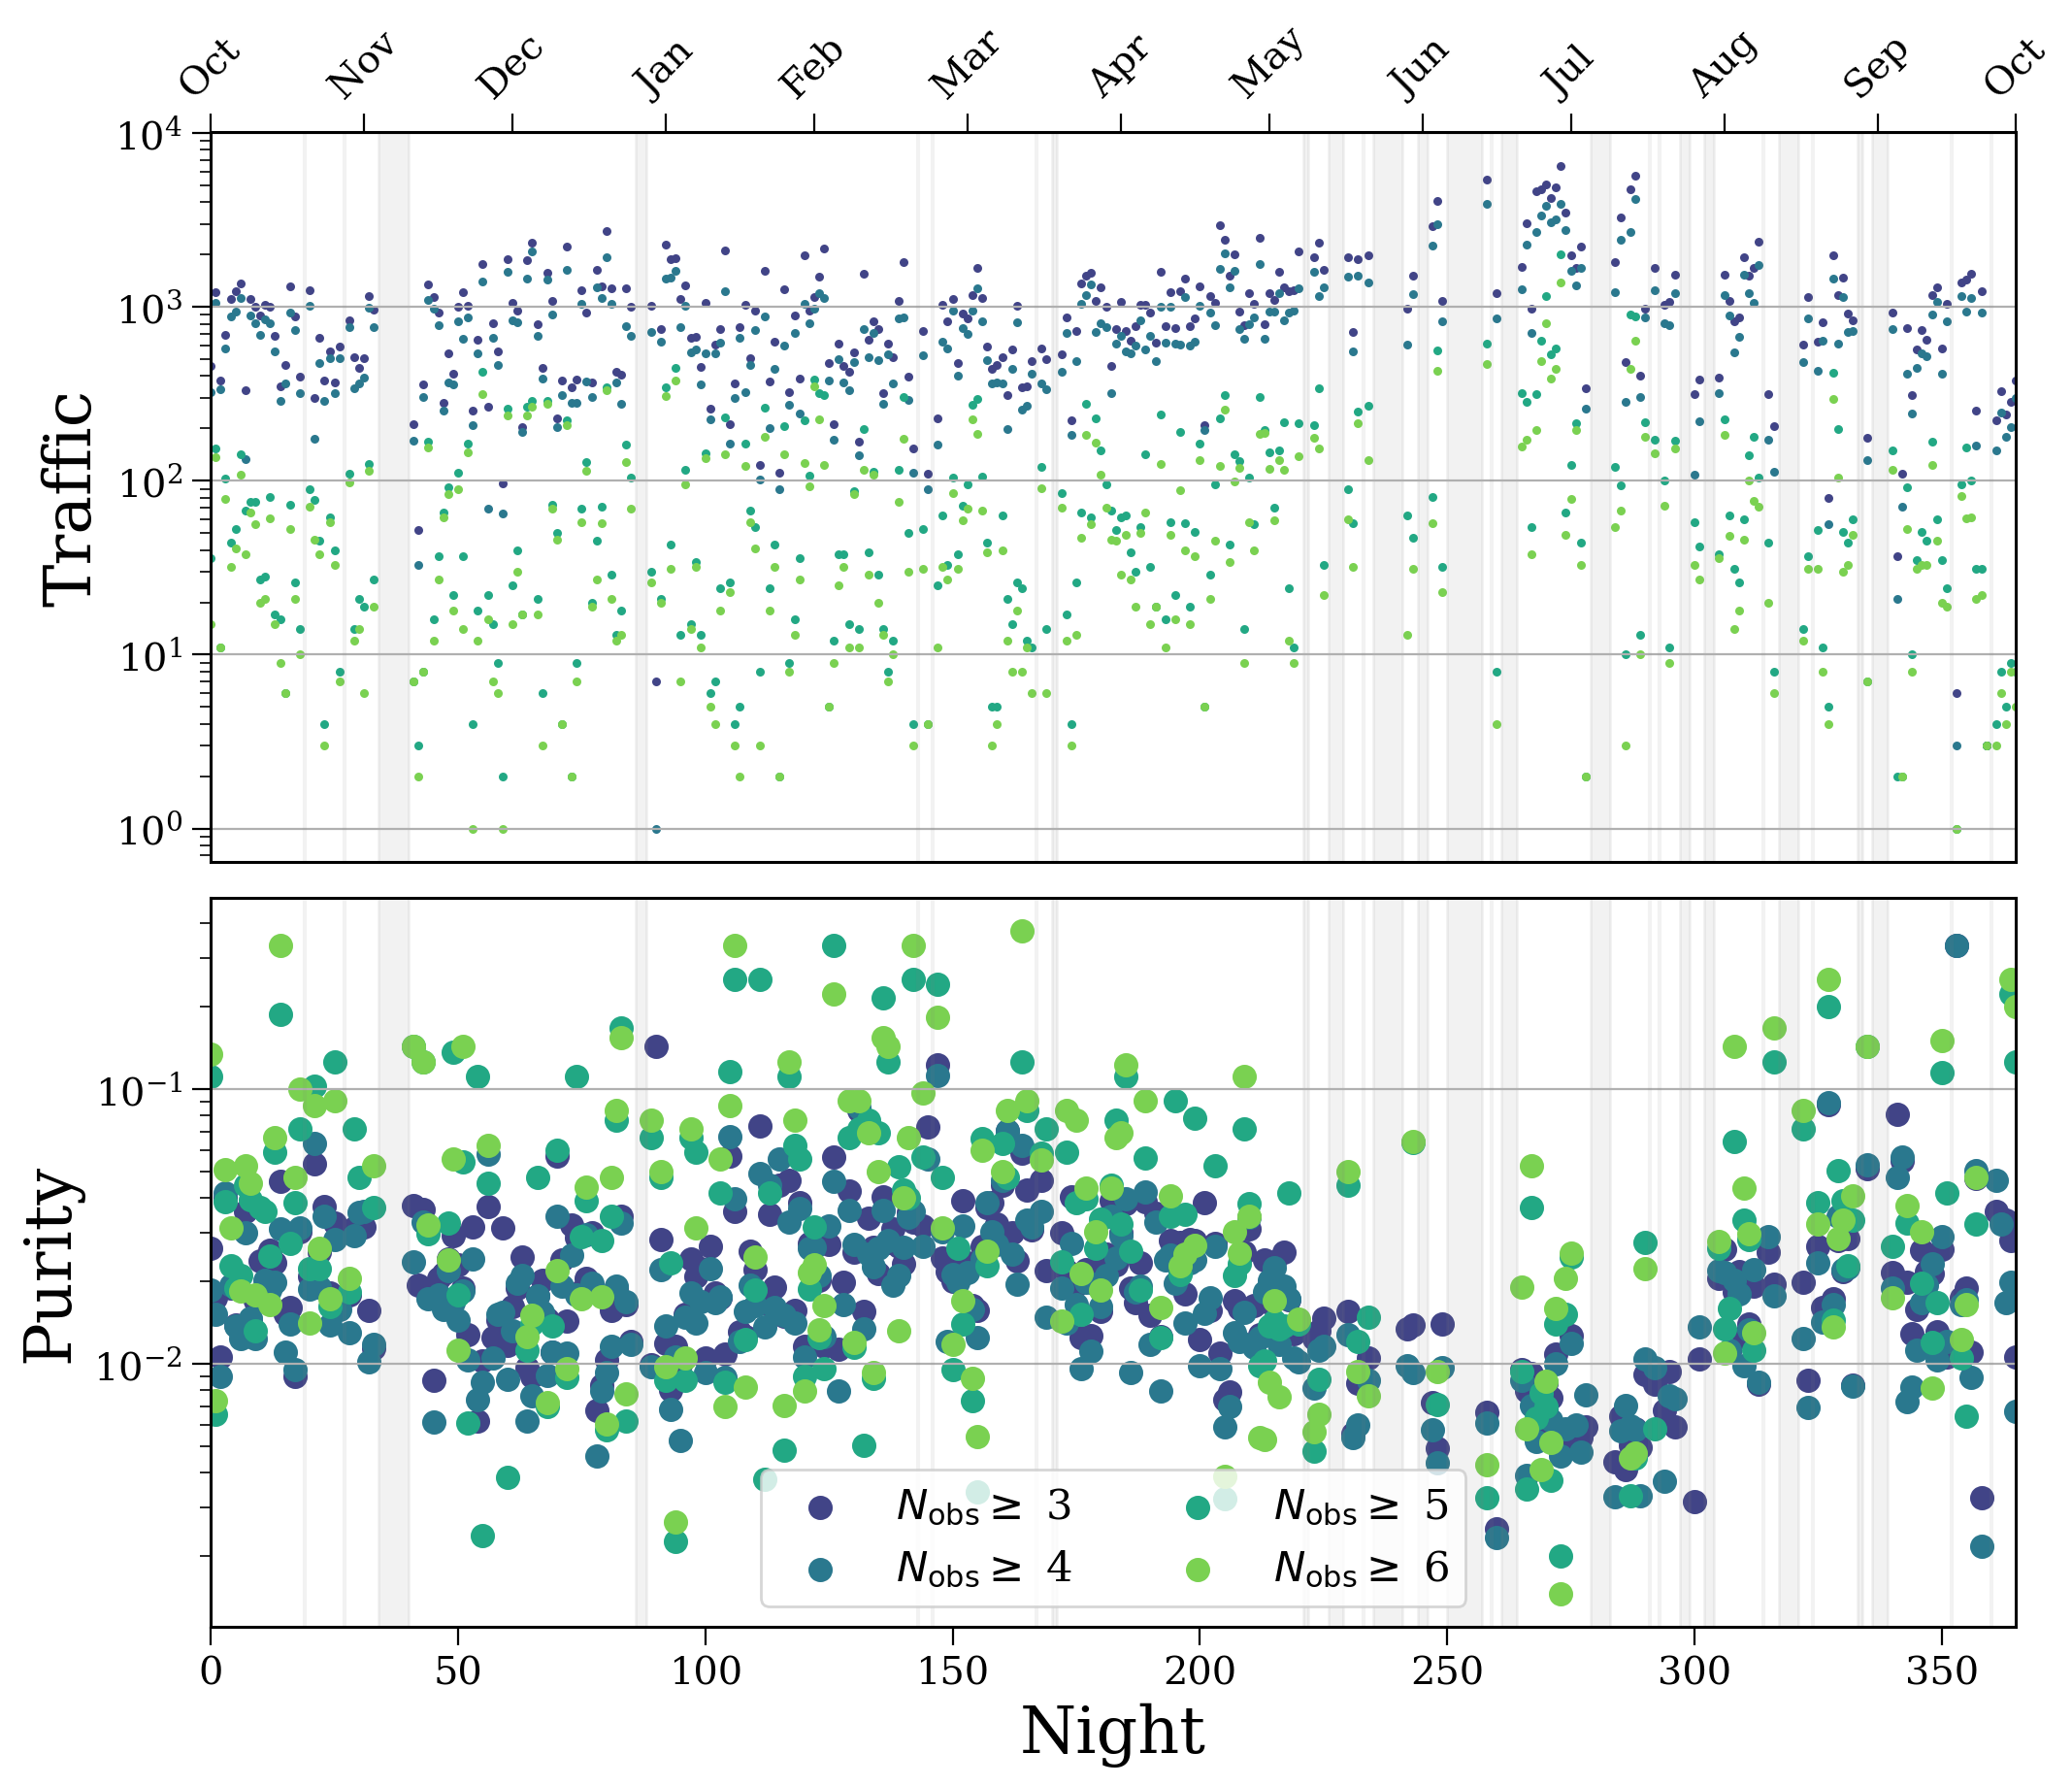

In [191]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10))
fig.subplots_adjust(hspace=0.05)

colours = [plt.get_cmap("viridis", len(n_obs_list) + 2)(i + 1) for i in range(len(n_obs_list))]
lw = 3

for i in range(len(n_obs_list)):
    axes[0].scatter(nights, total_traffic.T[i + 1],
                    color=colours[i], s=5)
axes[0].set_ylabel("Traffic")
axes[0].set_yscale("log")

for i in range(len(n_obs_list)):
    axes[1].scatter(nights, purity.T[i + 1],
                 label=fr"$N_{{\rm obs}} \geq$ {n_obs_list[i]}",
                 color=colours[i], lw=3)
    
axes[1].set_yscale("log")
axes[1].set_xlabel("Night")
axes[1].set_ylabel("Purity")
    
leg = axes[1].legend(loc="lower center", ncol=2, fontsize=0.65*fs)#, bbox_to_anchor=(0.3, 1))
# for legobj in leg.legendHandles:
#     legobj.set_linewidth(5.0)

labels = ["October", "November", "December", "January", "February",
          "March", "April", "May", "June", "July", "August", "September", "October"]
labels_short = [label[:3] for label in labels]
days = [0 for label in labels]
for i, month in enumerate(range(3, 16)):
    act_month, year = month % 12, month // 12
    if act_month == 0:
        act_month = 12
        year = 0
    days[i] = (date(2022 + year, act_month, 1) - date(2022, 3, 1)).days
    

axes[0].xaxis.tick_top()
axes[0].xaxis.set_label_position('top') 
    
axes[0].set_xticks(days)
axes[0].set_xticklabels(labels_short, rotation=45)

for ax in axes:
    ax.set_xlim(0, 365)
    ax.grid(axis="y")
    
    # loop over every day of bad weather
    i = 0
    while i < len(bad_weather):
        # if this is not the last entry and the subsequent entry is a contiguous block of nights
        if i < len(bad_weather) - 1 and bad_weather[i + 1] - bad_weather[i] == 1:
            # track the lower edge of the bad weather gap
            gap_low = bad_weather[i]
            i += 1
            while bad_weather[i] - bad_weather[i - 1] == 1 and i < len(bad_weather) - 1:
                i += 1
            gap_high = bad_weather[i - 1]
            
            ax.axvspan(gap_low, gap_high, color="grey", alpha=0.1)
        else:
            ax.axvline(bad_weather[i], color="grey", alpha=0.1)
            i += 1
            
# plt.savefig("../paper/figures/traffic_purity.pdf", format="pdf", bbox_inches="tight")

plt.show()

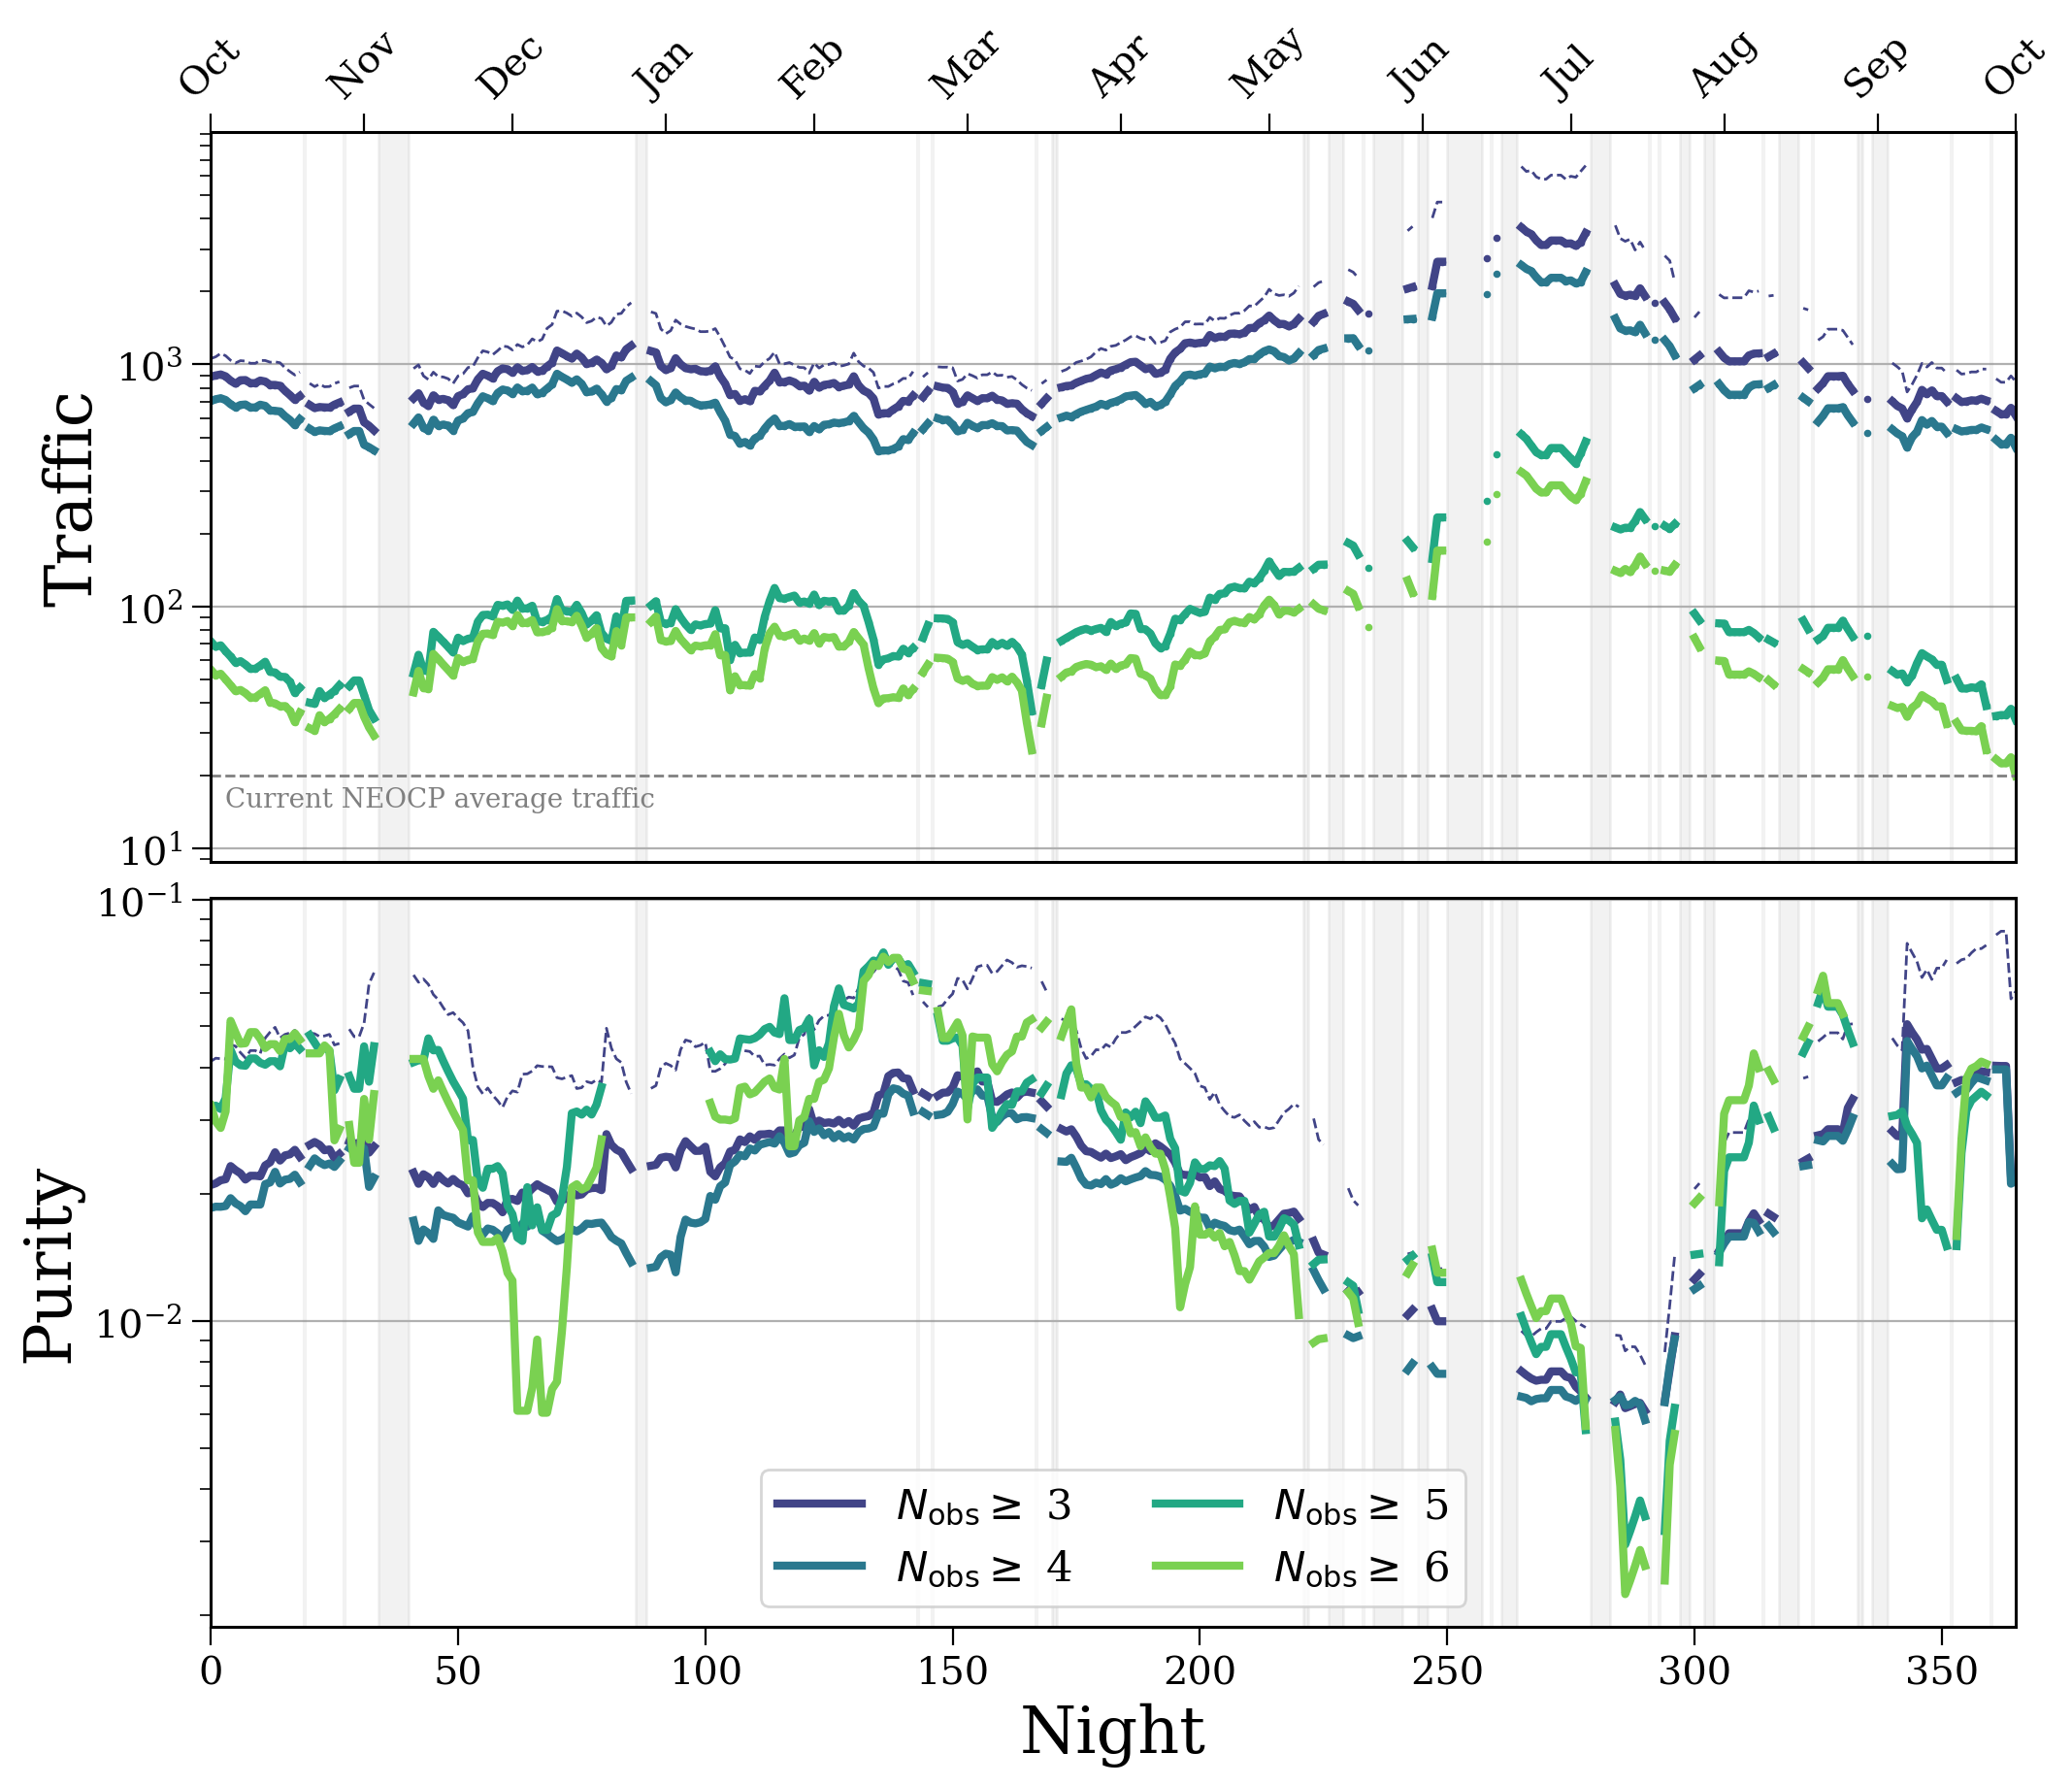

In [207]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10))
fig.subplots_adjust(hspace=0.05)

colours = [plt.get_cmap("viridis", len(n_obs_list) + 2)(i + 1) for i in range(len(n_obs_list))]
lw = 3

smoothing_window = 10

for i in range(len(n_obs_list)):
    axes[0].plot(nights, weekly_mean(total_traffic.T[i + 1], bad_weather, size=smoothing_window),
                 color=colours[i], lw=3, marker="o", markersize=np.sqrt(3))
axes[0].plot(nights, weekly_mean(total_traffic.T[0], bad_weather, size=smoothing_window),
             color=colours[0], lw=1, linestyle="--")
axes[0].set_ylabel("Traffic")
axes[0].set_yscale("log")

axes[1].plot(nights, weekly_mean(purity.T[0], bad_weather, size=smoothing_window),
             #label=fr"$N_{{\rm obs}} \geq$ {n_obs_list[0]}, all $m$",
             color=colours[0], lw=1, linestyle="--")
for i in range(len(n_obs_list)):
    axes[1].plot(nights, weekly_mean(purity.T[i + 1], bad_weather, size=smoothing_window),
                 label=fr"$N_{{\rm obs}} \geq$ {n_obs_list[i]}",
                 color=colours[i], lw=3)
    
axes[1].set_yscale("log")
axes[1].set_xlabel("Night")
axes[1].set_ylabel("Purity")
    
leg = axes[1].legend(loc="lower center", ncol=2, fontsize=0.65*fs)#, bbox_to_anchor=(0.3, 1))
# for legobj in leg.legendHandles:
#     legobj.set_linewidth(5.0)

labels = ["October", "November", "December", "January", "February",
          "March", "April", "May", "June", "July", "August", "September", "October"]
labels_short = [label[:3] for label in labels]
days = [0 for label in labels]
for i, month in enumerate(range(3, 16)):
    act_month, year = month % 12, month // 12
    if act_month == 0:
        act_month = 12
        year = 0
    days[i] = (date(2022 + year, act_month, 1) - date(2022, 3, 1)).days
    

axes[0].xaxis.tick_top()
axes[0].xaxis.set_label_position('top') 
    
axes[0].set_xticks(days)
axes[0].set_xticklabels(labels_short, rotation=45)

for ax in axes:
    ax.set_xlim(0, 365)
    ax.grid(axis="y")
    
    # loop over every day of bad weather
    i = 0
    while i < len(bad_weather):
        # if this is not the last entry and the subsequent entry is a contiguous block of nights
        if i < len(bad_weather) - 1 and bad_weather[i + 1] - bad_weather[i] == 1:
            # track the lower edge of the bad weather gap
            gap_low = bad_weather[i]
            i += 1
            while bad_weather[i] - bad_weather[i - 1] == 1 and i < len(bad_weather) - 1:
                i += 1
            gap_high = bad_weather[i - 1]
            
            ax.axvspan(gap_low, gap_high, color="grey", alpha=0.1)
        else:
            ax.axvline(bad_weather[i], color="grey", alpha=0.1)
            i += 1
            
axes[0].axhline(20, color="grey", linestyle="--", lw=1)
axes[0].annotate("Current NEOCP average traffic", xy=(3, 18), ha="left", va="top", color="grey")
            
# plt.savefig("../paper/figures/traffic_purity.pdf", format="pdf", bbox_inches="tight")

plt.show()

# Traffic and Purity with future knowledge

Let's apply `difi` to see which ones are findable

In [212]:
def get_findable_hex_ids(path="neo/", file_ids=range(22)):
                         
    obs_dfs = [pd.read_hdf(path + f"filtered_visit_scores_{i:03d}.h5").sort_values("FieldMJD")[["FieldMJD", "night", "MaginFilter", "filter"]]
               for i in file_ids]
    all_obs = pd.concat(obs_dfs)
    
    out_v_mag = magnitudes.convert_colour_mags(all_obs["MaginFilter"].values, out_colour="V",
                                               in_colour=all_obs["filter"].values)
    all_obs = all_obs[(out_v_mag <= 22) & (all_obs["scores"] >= 65)][["FieldMJD", "night"]]
    all_obs["obs_id"] = np.arange(len(all_obs))
    all_obs.reset_index(inplace=True)
    
    print("Obs file done")

    findable_hex_ids = None

    all_truths, findable_obs, summary = difi.analyzeObservations(
        observations=all_obs,
        classes=None,
        metric="nightly_linkages",
        column_mapping={"obs_id": "obs_id", "truth": "hex_id", "night": "night", "time": "FieldMJD"}
    )

    findable_hex_ids = all_truths[all_truths["findable"] == 1]["hex_id"].values

    return findable_hex_ids

In [213]:
%%time
findable_neo_hex_ids = get_findable_hex_ids()

KeyError: 'scores'

In [9]:
np.isin("000095E", findable_neo_hex_ids)

array(True)

In [6]:
%%time
findable_mba_hex_ids = get_findable_hex_ids(path="mba/")

Obs file done
CPU times: user 40min 59s, sys: 4min 15s, total: 45min 14s
Wall time: 44min 57s


In [7]:
unique_findable_neo_hex_ids = np.unique(findable_neo_hex_ids)
unique_findable_mba_hex_ids = np.unique(findable_mba_hex_ids)

In [8]:
np.save("unique_findable_neo_hex_ids_linked.npy", unique_findable_neo_hex_ids)
np.save("unique_findable_mba_hex_ids_linked.npy", unique_findable_mba_hex_ids)

In [44]:
unique_findable_neo_hex_ids = np.load("unique_findable_neo_hex_ids_linked.npy", allow_pickle=True)
unique_findable_mba_hex_ids = np.load("unique_findable_mba_hex_ids_linked.npy", allow_pickle=True)

In [45]:
def get_counts(path="neo/", n_obs_list=[2, 3, 4, 5, 6], last_night=377, findable_hex_ids=None):
    counts = np.zeros((last_night, len(n_obs_list))).astype(int)

    for file in range(24):
        print(f"file {file}")
        visit_file = pd.read_hdf(path + f"filtered_visit_scores_{file:03d}.h5")
        nights = visit_file["night"].unique()
        for night in nights:
            if night >= last_night:
                break
            nightly_visit = visit_file[visit_file["night"] == night]
            grouped = nightly_visit.groupby("hex_id").first()

            if findable_hex_ids is not None:
                grouped = grouped[~grouped.index.isin(findable_hex_ids)]
                
            if path == "neo/":
                no_streaks = ~(np.isin(grouped["ObjID"], neo_streakers["ObjID"][neo_streakers["night"] == night]))
                grouped = grouped[no_streaks]
            
            for i, n_obs in enumerate(n_obs_list):
                counts[night, i] += len(grouped[np.logical_and(grouped["n_obs"] >= n_obs,
                                                               grouped["scores"] >= 65)])
    return counts

In [46]:
neo_counts_unfindable = get_counts(findable_hex_ids=unique_findable_neo_hex_ids)

file 0
file 1
file 2
file 3
file 4
file 5
file 6
file 7
file 8
file 9
file 10
file 11
file 12
file 13
file 14
file 15
file 16
file 17
file 18
file 19
file 20
file 21
file 22
file 23


In [47]:
%%time
mba_counts_unfindable = get_counts(path="mba/", findable_hex_ids=unique_findable_mba_hex_ids)

file 0
file 1
file 2
file 3
file 4
file 5
file 6
file 7
file 8
file 9
file 10
file 11
file 12
file 13
file 14
file 15
file 16
file 17
file 18
file 19
file 20
file 21
file 22
file 23
CPU times: user 10min 23s, sys: 57.5 s, total: 11min 20s
Wall time: 11min 17s


In [48]:
total_traffic_unfindable = neo_counts_unfindable + mba_counts_unfindable

In [49]:
purity_unfindable = neo_counts_unfindable / total_traffic_unfindable

/tmp/ipykernel_53480/1320287732.py:1: RuntimeWarning: invalid value encountered in true_divide
  purity_unfindable = neo_counts_unfindable / total_traffic_unfindable


0.0
0.18078544304686048
0.0
0.16954457491474254


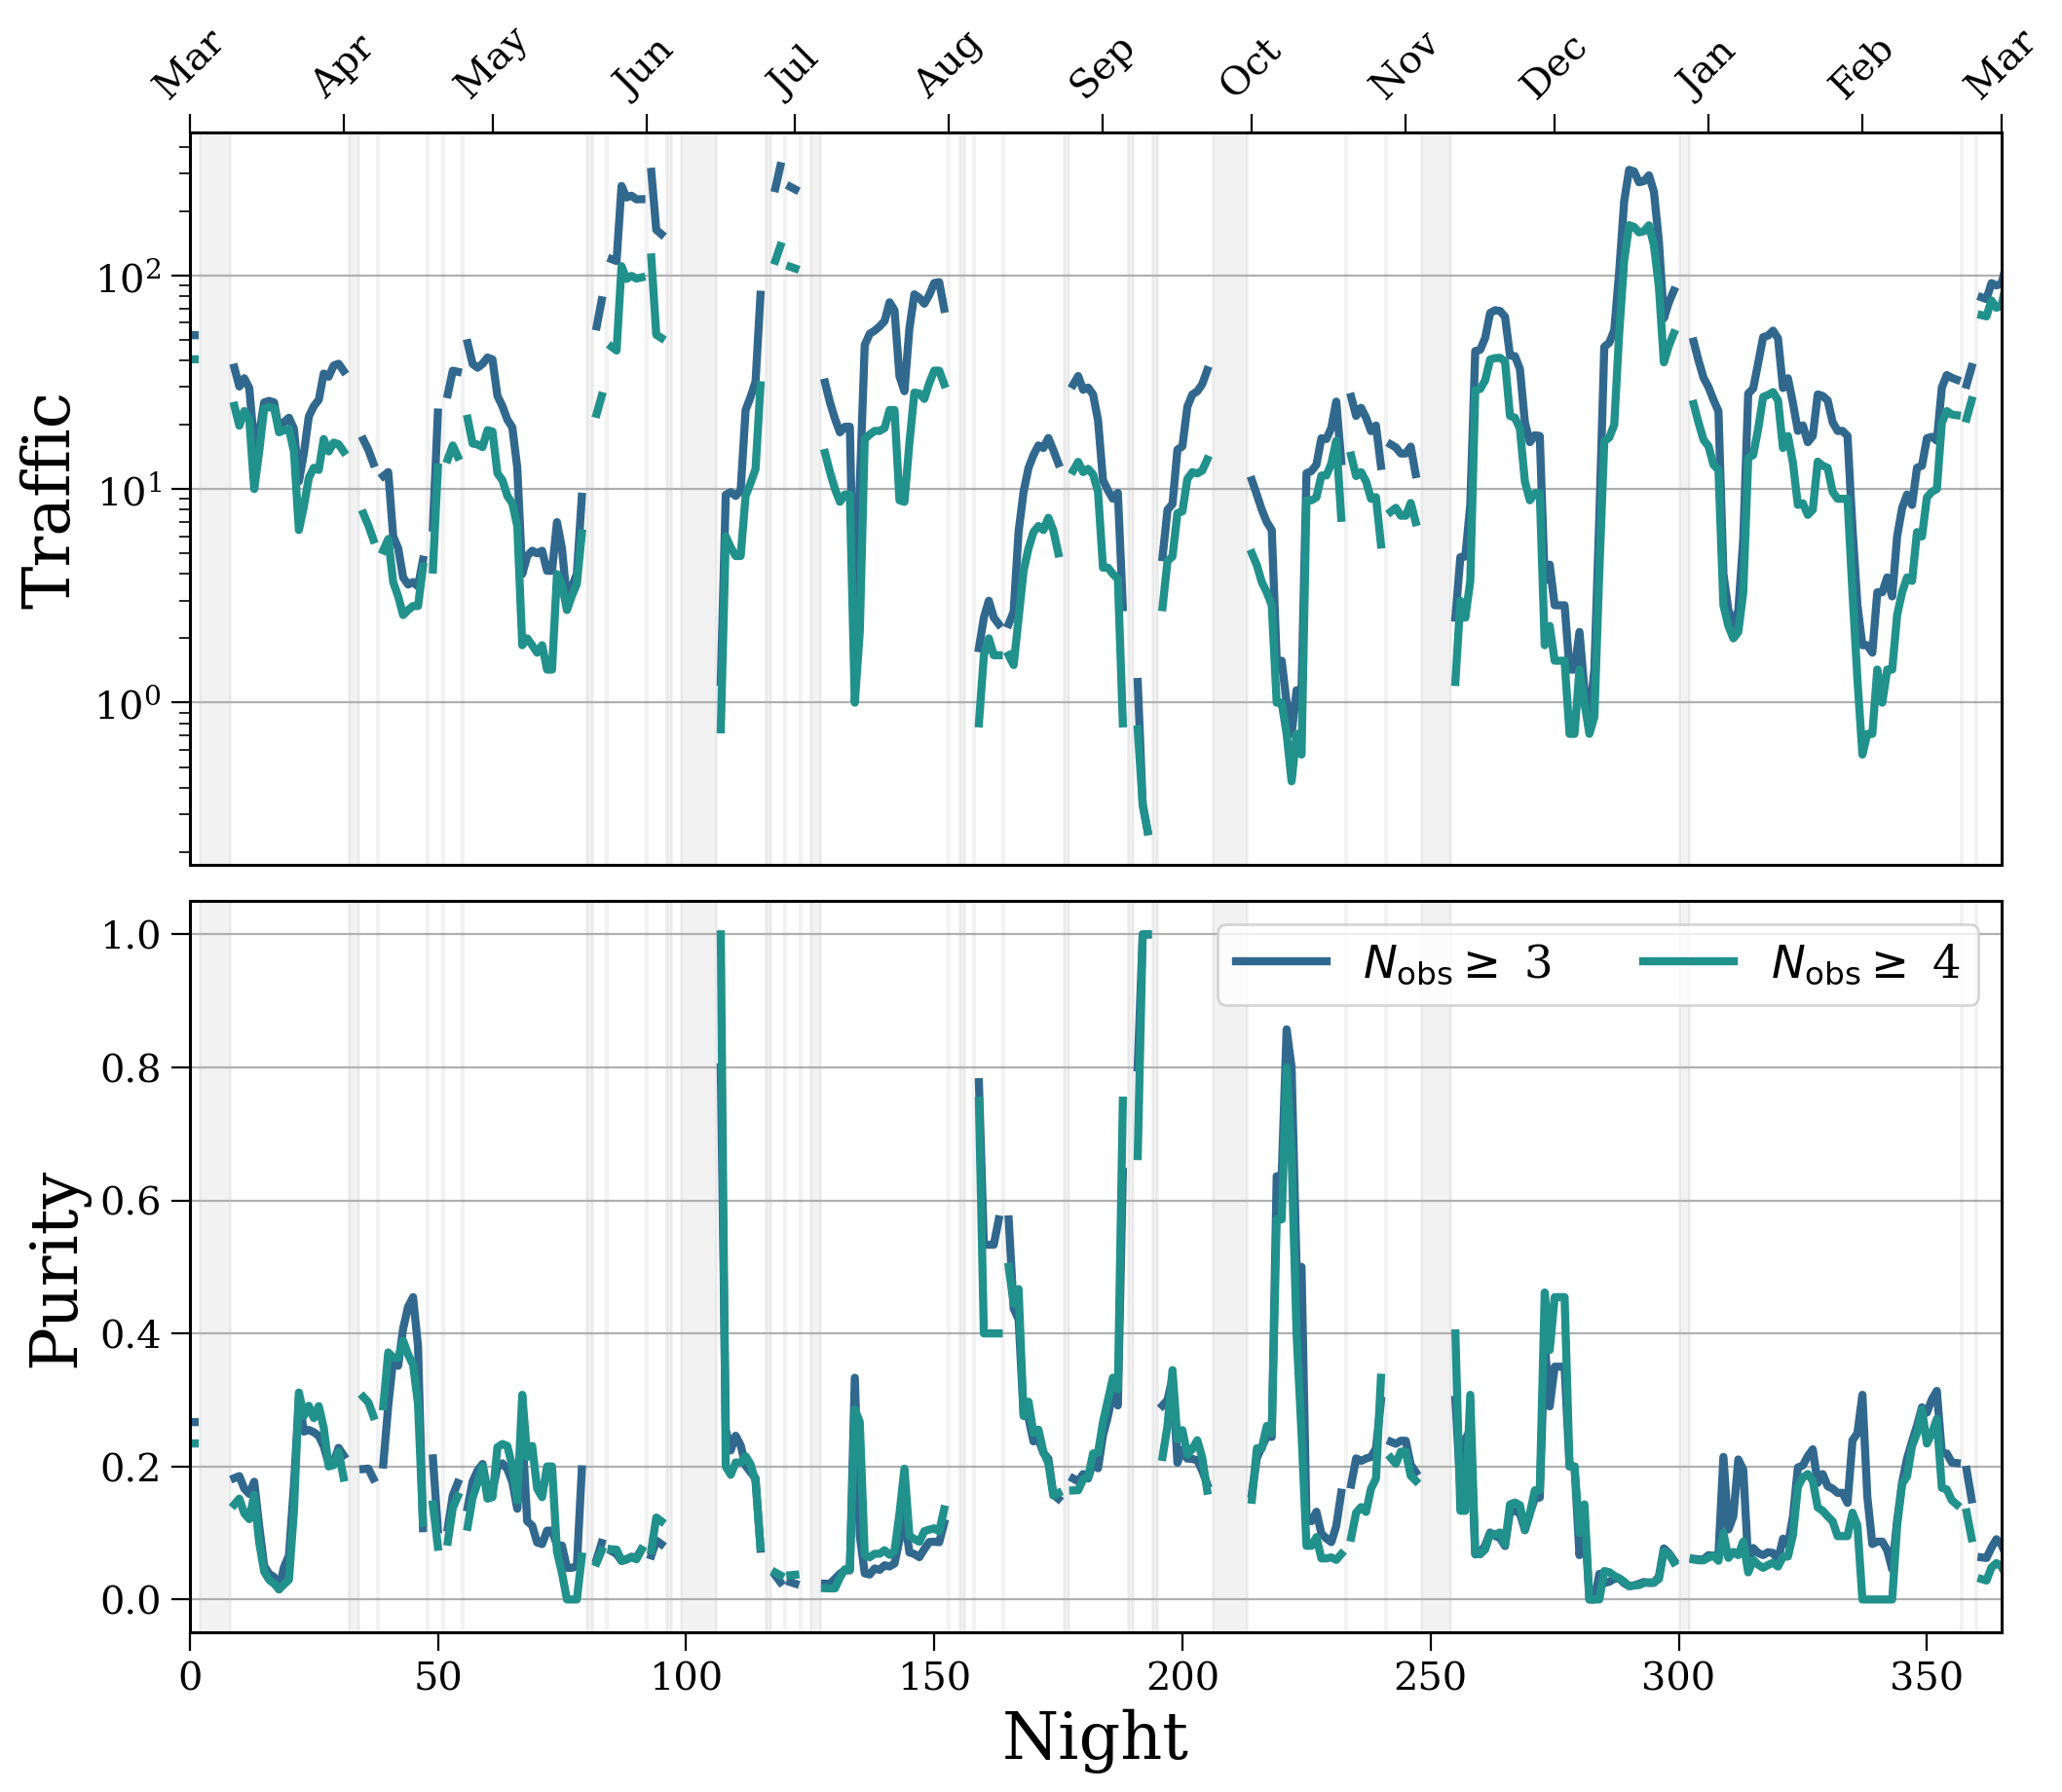

In [51]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10))
fig.subplots_adjust(hspace=0.05)

colours = [plt.get_cmap("viridis", len(n_obs_list) + 2)(i + 1) for i in range(len(n_obs_list))]
lw = 3

n_obs_range = [1, 2]

for i in n_obs_range:#range(len(n_obs_list)):
    axes[0].plot(nights, weekly_mean(total_traffic_unfindable.T[i], bad_weather),
                 color=colours[i], lw=3)
axes[0].set_ylabel("Traffic")
axes[0].set_yscale("log")

for i in n_obs_range:#range(len(n_obs_list)):
    purity = weekly_mean(neo_counts_unfindable.T[i], bad_weather) / weekly_mean(total_traffic_unfindable.T[i], bad_weather)
    axes[1].plot(nights, purity,
                 label=fr"$N_{{\rm obs}} \geq$ {n_obs_list[i]}",
                 color=colours[i], lw=3)
    print(np.min(purity[np.logical_not(np.isnan(purity))]))
    print(np.mean(purity[np.logical_not(np.isnan(purity))]))
    
# axes[1].set_yscale("log")
axes[1].set_xlabel("Night")
axes[1].set_ylabel("Purity")

# leg = axes[0].legend(loc="center right", bbox_to_anchor=(1.32, 0))
# for legobj in leg.legendHandles:
#     legobj.set_linewidth(5.0)
    
leg = axes[1].legend(loc="upper right", ncol=2, fontsize=0.7*fs)
# for legobj in leg.legendHandles:
#     legobj.set_linewidth(5.0)

labels = ["March", "April", "May", "June", "July", "August", "September",
          "October", "November", "December", "January", "February", "March"]
labels_short = [label[:3] for label in labels]
days = [0 for label in labels]
for i, month in enumerate(range(3, 16)):
    act_month, year = month % 12, month // 12
    if act_month == 0:
        act_month = 12
        year = 0
    days[i] = (date(2022 + year, act_month, 1) - date(2022, 3, 1)).days
    

axes[0].xaxis.tick_top()
axes[0].xaxis.set_label_position('top') 
    
axes[0].set_xticks(days)
axes[0].set_xticklabels(labels_short, rotation=45)

for ax in axes:
    ax.set_xlim(0, 365)
    ax.grid(axis="y")
    
    i = 0
    while i < len(bad_weather):
        if i < len(bad_weather) - 1 and bad_weather[i + 1] - bad_weather[i] == 1:
            gap_low = bad_weather[i]
            i += 1
            while bad_weather[i] - bad_weather[i - 1] == 1 and i < len(bad_weather):
                i += 1
            gap_high = bad_weather[i - 1]
            
            ax.axvspan(gap_low, gap_high, color="grey", alpha=0.1)
        else:
            ax.axvline(bad_weather[i], color="grey", alpha=0.1)
            i += 1
            
plt.savefig("../paper/figures/traffic_purity_unfindable.pdf", format="pdf", bbox_inches="tight")

plt.show()

# Sky projections

## Set up ecliptic plane

In [9]:
lon = coord.Angle(np.linspace(-180, 179.9, 1000)*u.degree)
lat = coord.Angle(np.zeros(1000)*u.degree)

ecliptic = coord.SkyCoord(lon=lon, lat=lat, frame='geocentrictrueecliptic').transform_to("icrs")
ecliptic.ra.radian = coord.Angle(ecliptic.ra).wrap_at('180d').radian

## Get RA/Dec

In [30]:
total_neo_obs = 0
for file in range(207):
    x = pd.read_hdf(f"/data/epyc/projects/jpl_survey_sim/10yrs/detections/march_start_v2.1/S0/visit-{int(file * 1e4):07}.h5")
    total_neo_obs += len(x)
    del x

In [35]:
x = pd.read_hdf(f"/data/epyc/projects/jpl_survey_sim/10yrs/detections/march_start_v2.1/S0/visit-{int(207 * 1e4):07}.h5")

In [30]:
%%time
total_mba_obs = 0
for file in range(207):
    x = pd.read_hdf(f"/data/epyc/projects/jpl_survey_sim/10yrs/detections/march_start_v2.1/S0/visit-{int(file * 1e4):07}.h5")
    total_neo_obs += len(x)
    del x

In [119]:
def get_file_table(obj_type="NEO", max_nights=200, max_file=204, night_zero=60217):
    assert obj_type in ["NEO", "MBA"]
    
    # set the path to the observations
    if obj_type == "NEO":
        in_path = "/data/epyc/projects/jpl_survey_sim/10yrs/v3.0/detections/S0/"
    else:
        in_path = [f"/data/epyc/projects/jpl_survey_sim/10yrs/v3.0/detections/S1_{i:02d}/" for i in range(14)]

    table = []

    file = 0
    nights_done = 0
    while nights_done < max_nights and file <= max_file:
        if isinstance(in_path, str):
            df = pd.read_hdf(in_path + f"visit-{int(file * 1e4):07}.h5")
        else:
            dfs = [pd.read_hdf(in_path[i] + f"visit-{int(file * 1e4):07}.h5") for i in range(len(in_path))]
            df = pd.concat(dfs)
        df["night"] = (df["FieldMJD"] - 0.5).astype(int)
        df["night"] -= night_zero

        table.append(list(sorted(df["night"].unique())))

        nights_done = df["night"].max() - 1

        print(file, nights_done, end=" -- ")
        
        file += 1
    
    return table

In [124]:
pd.read_hdf("/data/epyc/projects/jpl_survey_sim/10yrs/v3.0/detections/S0/" + f"visit-{int(204 * 1e4):07}.h5")["FieldMJD"].max() - 60217

3596.110736080431

In [127]:
np.array(f2n_NEO, dtype='object')

array([list([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]),
       list([12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 28]),
       list([28, 29, 30, 31, 32, 33, 41, 42, 43, 44, 45, 46, 47, 48]),
       list([48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]),
       list([62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77]),
       list([77, 78, 79, 80, 81, 82, 83, 84, 85, 89, 90, 91, 92, 93, 94, 95]),
       list([95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110]),
       list([110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124]),
       list([124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137]),
       list([137, 138, 139, 140, 141, 142, 144, 145, 147, 148, 149, 150, 151, 152]),
       list([152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164]),
       list([164, 165, 166, 168, 169, 172, 173, 174, 175, 176, 177, 178, 179, 180]),
       list([180, 181, 182, 183, 184, 185, 186, 1

In [ ]:
f2n

In [120]:
%%time
f2n_NEO = get_file_table(max_nights=3652)

0 11 -- 1 27 -- 2 47 -- 3 61 -- 4 76 -- 5 94 -- 6 109 -- 7 123 -- 8 136 -- 9 151 -- 10 163 -- 11 179 -- 12 190 -- 13 201 -- 14 212 -- 15 224 -- 16 267 -- 17 283 -- 18 308 -- 19 329 -- 20 350 -- 21 373 -- 22 391 -- 23 416 -- 24 432 -- 25 452 -- 26 468 -- 27 483 -- 28 505 -- 29 522 -- 30 545 -- 31 571 -- 32 593 -- 33 630 -- 34 644 -- 35 656 -- 36 674 -- 37 688 -- 38 702 -- 39 721 -- 40 737 -- 41 751 -- 42 768 -- 43 785 -- 44 803 -- 45 824 -- 46 839 -- 47 854 -- 48 867 -- 49 880 -- 50 894 -- 51 906 -- 52 921 -- 53 938 -- 54 953 -- 55 969 -- 56 1006 -- 57 1022 -- 58 1035 -- 59 1048 -- 60 1075 -- 61 1090 -- 62 1113 -- 63 1137 -- 64 1151 -- 65 1166 -- 66 1185 -- 67 1202 -- 68 1216 -- 69 1231 -- 70 1246 -- 71 1260 -- 72 1271 -- 73 1286 -- 74 1303 -- 75 1315 -- 76 1333 -- 77 1366 -- 78 1380 -- 79 1393 -- 80 1403 -- 81 1417 -- 82 1433 -- 83 1456 -- 84 1469 -- 85 1497 -- 86 1514 -- 87 1528 -- 88 1545 -- 89 1561 -- 90 1577 -- 91 1590 -- 92 1607 -- 93 1622 -- 94 1637 -- 95 1654 -- 96 1666 -- 97 16

In [130]:
# f2n_NEO = get_file_table(obj_type="NEO")
# f2n_MBA = get_file_table(obj_type="MBA")
np.save("f2n.npy", np.array(f2n_NEO, dtype="object"))

## Plot it!

In [21]:
obs_dfs = [pd.read_hdf(f"neo/filtered_visit_scores_{i:03d}.h5").sort_values("FieldMJD")
            for i in [7]]
neo_obs = pd.concat(obs_dfs)

In [22]:
obs_dfs = [pd.read_hdf(f"mba/filtered_visit_scores_{i:03d}.h5").sort_values("FieldMJD")
            for i in [7]]
mba_obs = pd.concat(obs_dfs)

In [23]:
sky_positions = [
    {
        "obs": neo_obs,
        "label": "NEOs",
        "s": 0.1,
        "m": "o",
        "z": 10,
    },
    {
        "obs": mba_obs,
        "label": "MBAs",
        "s": 0.05,
        "m": "^",
        "z": 9
    }
]

1058
421119


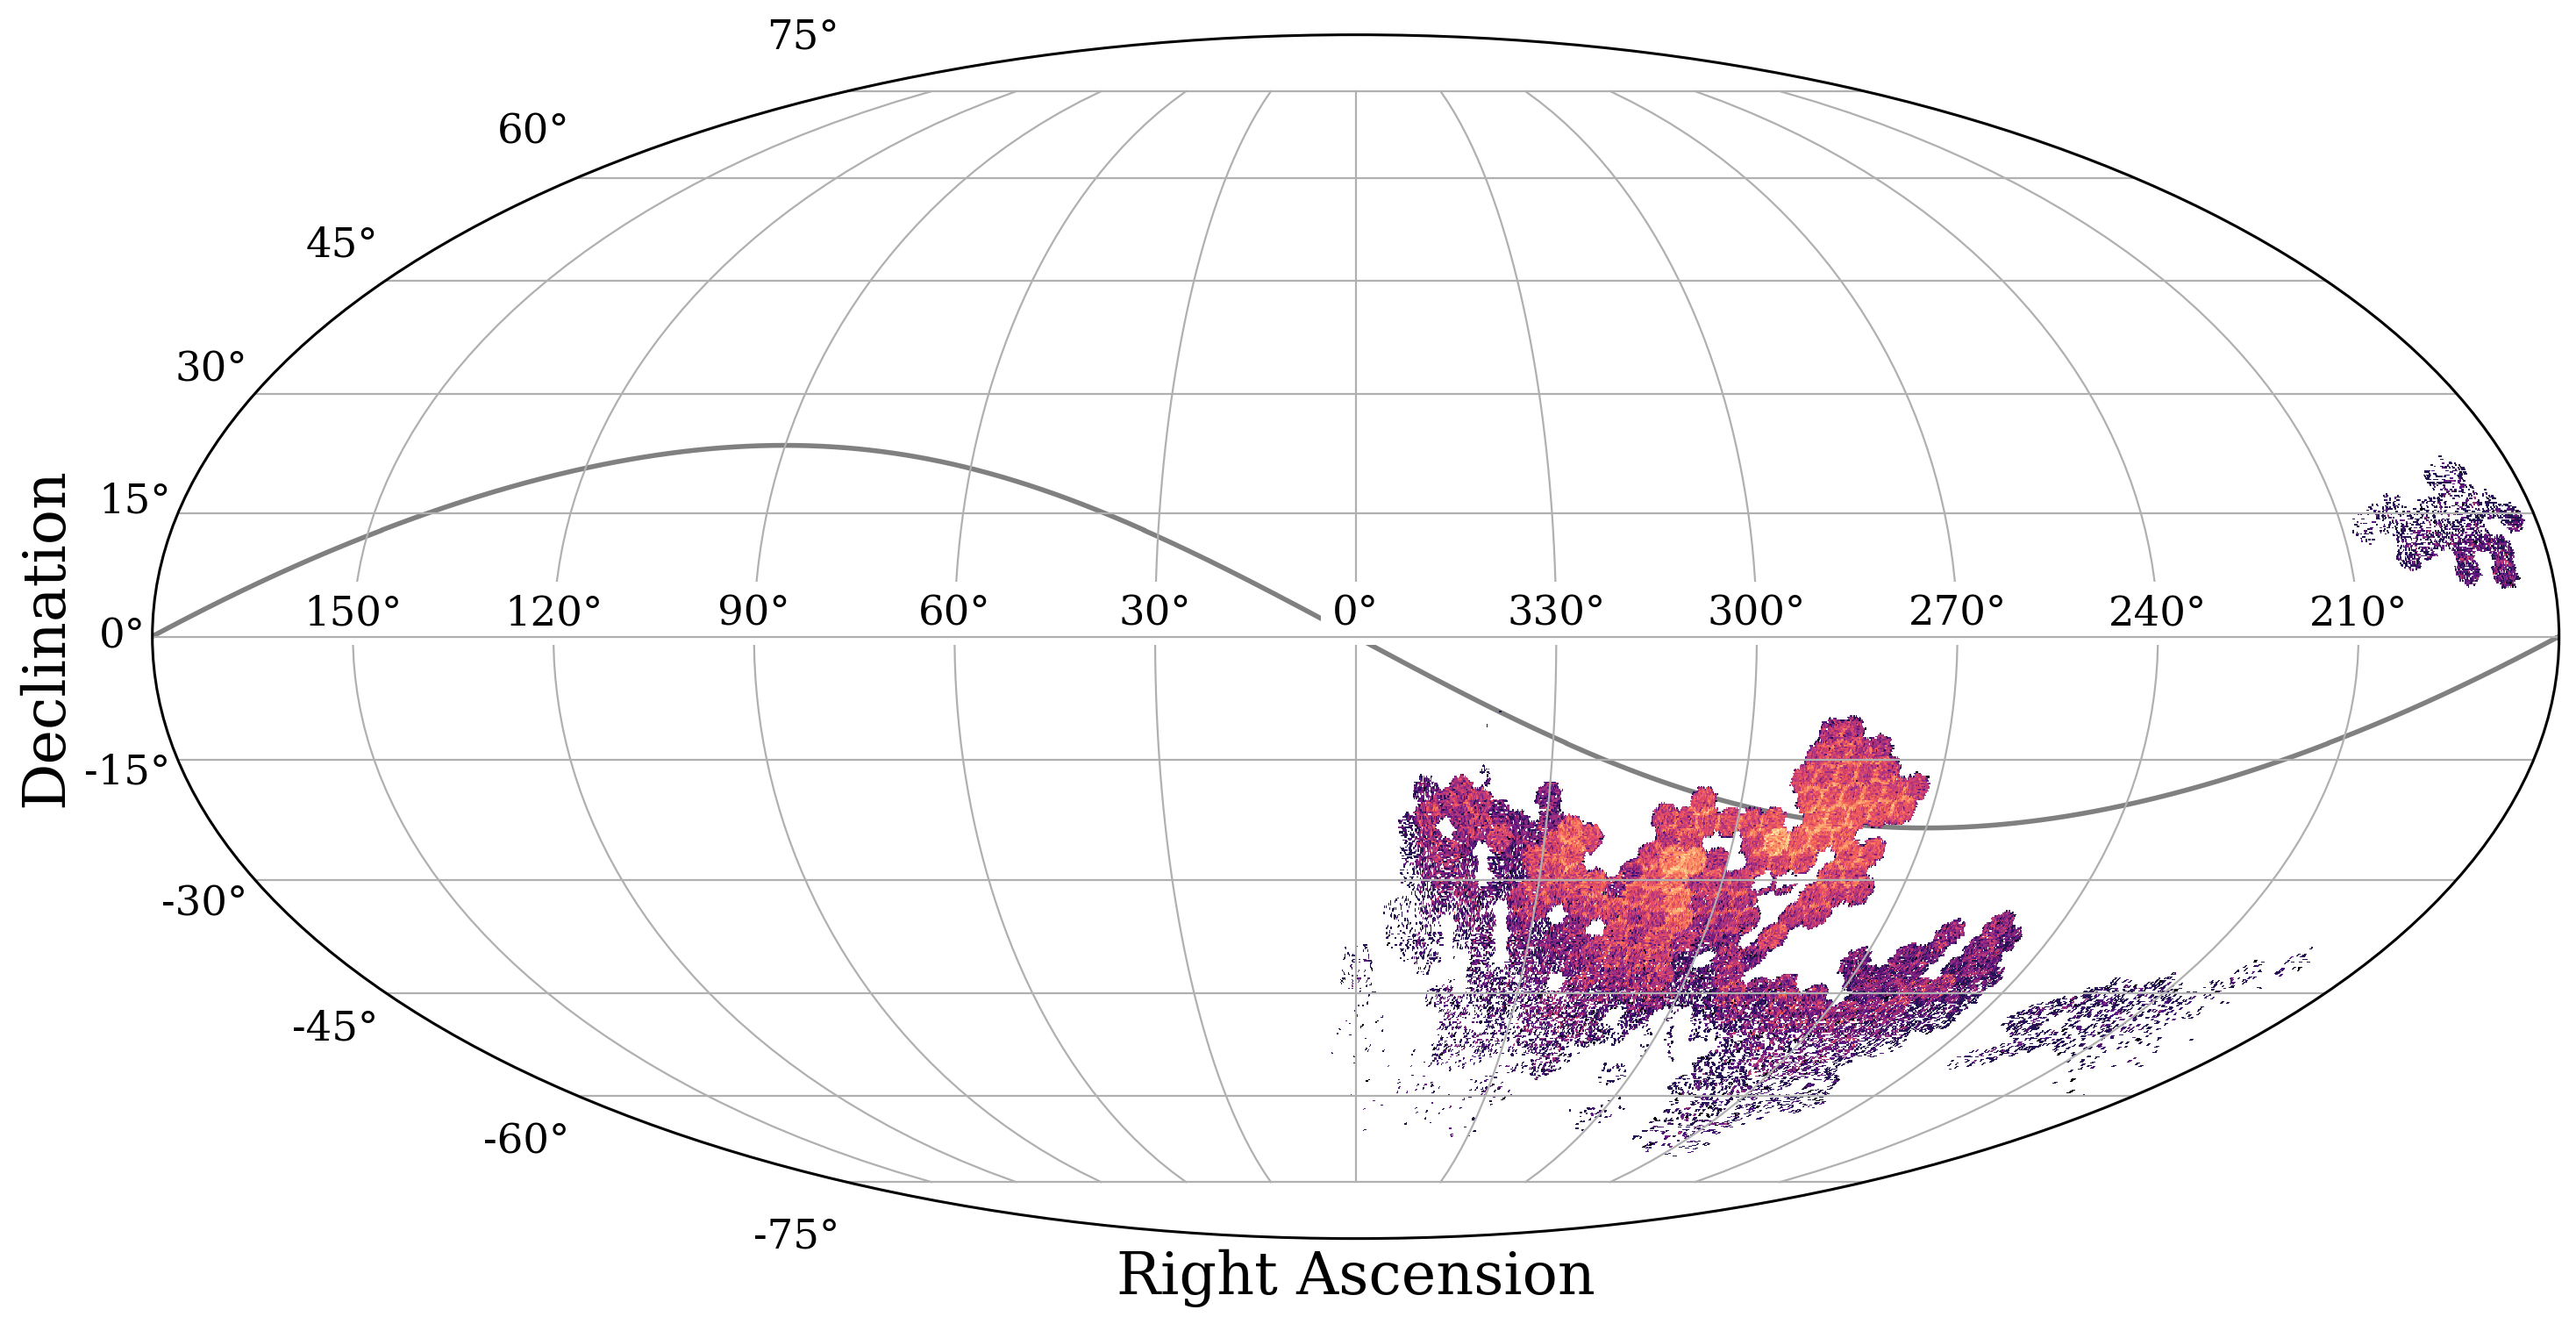

In [162]:
import healpy as hp
from matplotlib.colors import LogNorm

# I edited this from this example: https://github.com/zonca/paperplots/blob/master/python/scripts/PlanckFig_map.py

nside = int(2**8)

ra = np.array([])
dec = np.array([])
for obs in [neo_obs, mba_obs]:
    obs = obs[obs["night"] == night]
    print(len(obs))
    ra = np.concatenate((ra, obs["AstRA(deg)"].values))
    dec = np.concatenate((dec, obs["AstDec(deg)"].values))

ra, dec = np.radians(ra), np.radians(dec)
lat = np.pi / 2.0 - dec
hpids = hp.ang2pix(nside, lat, ra)

map_vals = np.zeros(hp.nside2npix(nside), dtype=float)
for idx in hpids:
    map_vals[idx] += 1

m = hp.ma(map_vals)

xsize = 2000
ysize = int(xsize/2)

theta = np.linspace(np.pi, 0, ysize)
phi   = np.linspace(-np.pi, np.pi, xsize)
longitude = np.radians(np.linspace(-180, 180, xsize))
latitude = np.radians(np.linspace(-90, 90, ysize))

# project the map to a rectangular matrix xsize x ysize
PHI, THETA = np.meshgrid(phi, theta)
grid_pix = hp.ang2pix(nside, THETA, PHI)

grid_map = m[grid_pix]

from matplotlib.projections.geo import GeoAxes

class ThetaFormatterShiftPi(GeoAxes.ThetaFormatter):
    """Shifts labelling by pi
    Shifts labelling from -180,180 to 0-360"""
    def __call__(self, x, pos=None):
        if x != 0:
            x *= -1
        if x < 0:
            x += 2*np.pi
        return GeoAxes.ThetaFormatter.__call__(self, x, pos)

fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(111, projection='mollweide')

# flip longitude to the astro convention
image = plt.pcolormesh(longitude[::-1], latitude, grid_map, rasterized=True, cmap=cmap, norm=LogNorm())

# graticule
ax.set_longitude_grid(30)
ax.xaxis.set_major_formatter(ThetaFormatterShiftPi(30))

ax.plot(ecliptic.ra.radian[::-1], ecliptic.dec.radian, color='grey', lw=2, zorder=-1)

# colorbar
# cb = fig.colorbar(image, orientation="horizontal", location="top", shrink=.6, pad=0.05)#, ticks=[vmin, vmax])
# cb.ax.xaxis.set_label_text("Number of Objects")
# cb.solids.set_edgecolor("face")

ax.set_xlabel("Right Ascension")
ax.set_ylabel("Declination")

for label in ax.get_xticklabels():
    label.set_bbox(dict(facecolor='white', edgecolor='None'))

ax.tick_params(axis="x", labelsize=0.7*fs)
ax.tick_params(axis="y", labelsize=0.7*fs)
    
# remove white space around figure
spacing = 0.01
plt.subplots_adjust(bottom=spacing, top=1-spacing, left=spacing, right=1-spacing)

plt.grid(True)

plt.savefig("../paper/figures/observations_example.pdf", format="pdf", bbox_inches="tight")

plt.show()

# Check tracklet lengths

In [6]:
def get_tracklet_length(df):
    init = SkyCoord(ra=df["AstRA(deg)"].iloc[0], dec=df["AstDec(deg)"].iloc[0], unit="deg")
    final = SkyCoord(ra=df["AstRA(deg)"].iloc[-1], dec=df["AstDec(deg)"].iloc[-1], unit="deg")
    
    return init.separation(final).to(u.arcsecond).value

In [16]:
mba_df = pd.read_hdf("mba/filtered_visit_000.h5")

In [20]:
%%time
mba_lengths = mba_df[mba_df["night"] == 0].groupby("ObjID").apply(get_tracklet_length)

CPU times: user 1min 4s, sys: 0 ns, total: 1min 4s
Wall time: 1min 4s


Text(0.5, 1.0, 'Tracklet lengths for night 0 of simulated data')

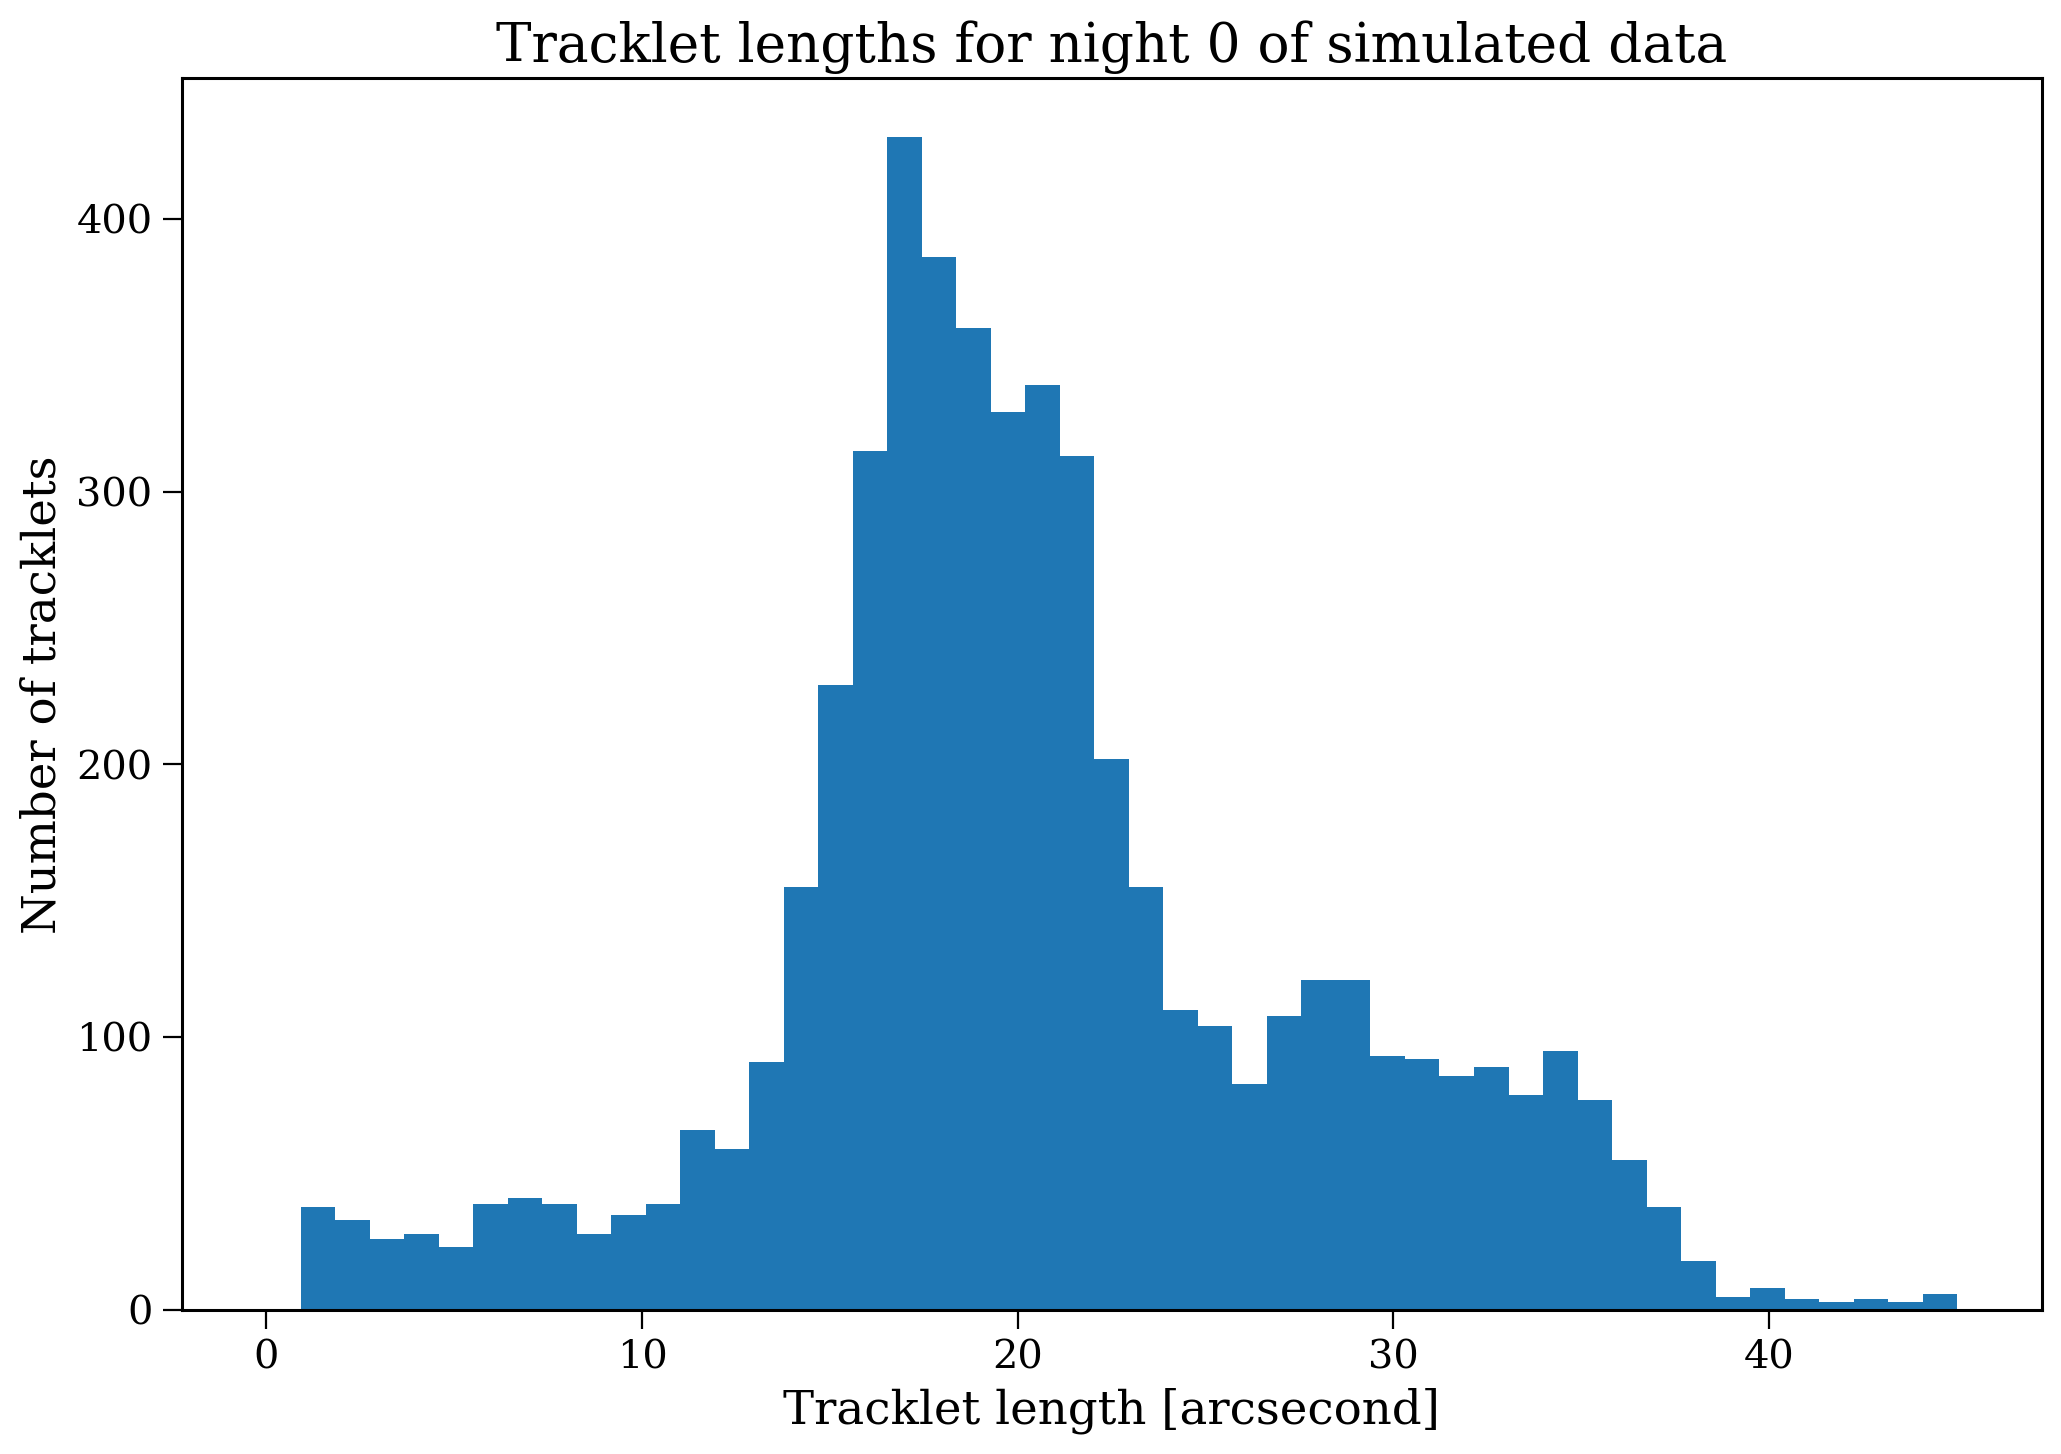

In [28]:
plt.hist(mba_lengths.values, bins="fd", range=(0, 45));
plt.xlabel("Tracklet length [arcsecond]", fontsize=0.7*fs)
plt.ylabel("Number of tracklets", fontsize=0.7*fs)
plt.title("Tracklet lengths for night 0 of simulated data", fontsize=0.8*fs)